# Comparaison de la prediction pour Poisson (sdf apprise) avec solution sur-raffinée FEM

In [1]:
import sys
import argparse

from scar.problem.Case import *
from scar.utils import *
from scar.equations.run_Poisson2D import *
from scar.geometry import Geometry2D

import dolfin as df
from dolfin import *
import mshr

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU
torch loaded; device is cuda
torch loaded; device is cuda


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Get FEM solution

In [2]:
geom_class_name = "Bean"
geom_class = get_class(geom_class_name,Geometry2D)
form = geom_class()

### Create mesh

In [3]:
def dist(pt1,pt2):
    return np.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)

def tri(c_t):
    n_bc_points = c_t.shape[0]
    c_t_tri = [c_t[0,:]]
    c_t = np.delete(c_t,0,axis=0)
    for _ in range(1,n_bc_points):
        pt1 = c_t_tri[-1]
        # point le plus proche de pt1
        dist_pts = [dist(pt1,c_t[i,:]) for i in range(len(c_t))]
        i_min = np.argmin(dist_pts)
        c_t_tri.append(c_t[i_min,:])
        c_t = np.delete(c_t,i_min,axis=0)
    return np.array(c_t_tri)

In [20]:
n_bc_points = 30
t = np.linspace(0,1,n_bc_points)
c_t = form.c(t)
c_t = np.array(c_t.T)

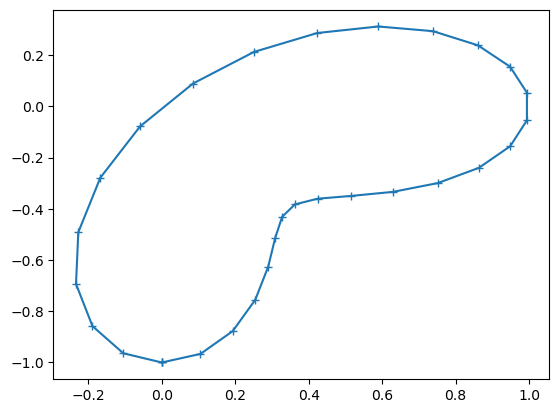

In [21]:
c_t_tri = tri(c_t)
c_t_tri = np.concatenate([c_t_tri,np.array([c_t_tri[0]])],axis=0)

# plot
plt.plot(c_t_tri[:,0],c_t_tri[:,1],"-+")
plt.show()

In [22]:
dist_2pts = [dist(c_t_tri[i,:],c_t_tri[i+1,:]) for i in range(n_bc_points)]
dist_2pts = np.array(dist_2pts)
dist_2pts

array([2.44929360e-16, 1.10303328e-01, 1.25318775e-01, 1.36768215e-01,
       1.33790587e-01, 1.14456722e-01, 8.43305159e-02, 5.96159741e-02,
       6.56474849e-02, 9.19207916e-02, 1.14956039e-01, 1.26699922e-01,
       1.26951095e-01, 1.19751447e-01, 1.11394629e-01, 1.07802119e-01,
       1.11451531e-01, 1.21003309e-01, 1.34227763e-01, 1.50028832e-01,
       1.68100184e-01, 1.87677509e-01, 2.06623739e-01, 2.21350000e-01,
       2.27564529e-01, 2.21577812e-01, 2.01843684e-01, 1.70540995e-01,
       1.35338792e-01, 1.10831583e-01])

In [23]:
# ecart type
np.std(dist_2pts)

0.05035156654584632

In [ ]:
class Bean(ParametricCurves):
    def __init__(self,a=3,b=5):
        self.name = self.__class__.__name__
        self.bord_a,self.bord_b = (-0.5,1.5)
        self.bord_a2,self.bord_b2 = (-1.5,0.5)
        self.a = a
        self.b = b
        self.theta = -np.pi/2
    
    def R(self):
        # rot = np.array([[np.cos(self.theta),-np.sin(self.theta)],[np.sin(self.theta),np.cos(self.theta)]])
        rot = torch.Tensor([[np.cos(self.theta),-np.sin(self.theta)],[np.sin(self.theta),np.cos(self.theta)]])
        return rot
    
    def c(self,t):
        x = (np.sin(2*np.pi*t)**self.a+np.cos(2*np.pi*t)**self.b)*np.cos(2*np.pi*t)
        y = (np.sin(2*np.pi*t)**self.a+np.cos(2*np.pi*t)**self.b)*np.sin(2*np.pi*t)

        # return self.R() @ np.array([x,y])
        return self.R()@torch.Tensor([x,y])
    
    def c_prime(self, t):
        x = (2*np.pi*self.a*np.sin(2*np.pi*t)**(self.a-1)*np.cos(2*np.pi*t) - 2*np.pi*self.b*np.sin(2*np.pi*t)*np.cos(2*np.pi*t)**(self.b-1))*np.cos(2*np.pi*t) - 2*np.pi*(np.sin(2*np.pi*t)**self.a + np.cos(2*np.pi*t)**self.b)*np.sin(2*np.pi*t)

        y = (2*np.pi*self.a*np.sin(2*np.pi*t)**(self.a-1)*np.cos(2*np.pi*t) - 2*np.pi*self.b*np.sin(2*np.pi*t)*np.cos(2*np.pi*t)**(self.b-1))*np.sin(2*np.pi*t) + 2*np.pi*(np.sin(2*np.pi*t)**self.a + np.cos(2*np.pi*t)**self.b)*np.cos(2*np.pi*t)

        # return self.R() @ np.array([x,y])
        return self.R()@torch.Tensor([x,y])